In [17]:
%load_ext autoreload
%autoreload 2

from tweedejaars_project import *
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import *
from sklearn.preprocessing import *
from sklearn.compose import *
from sklearn.kernel_approximation import *
from sklearn.model_selection import *
from sklearn.metrics import *
from sklearn.ensemble import *
from sklearn.tree import *
from sklearn.neural_network import *
from sklearn.linear_model import *
import xgboost as xgb
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer, MissingIndicator
from statsmodels.tsa.statespace.sarimax import SARIMAX

from numba import jit

# import os
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'


df = load_df()


def to_category(df: pd.DataFrame, feature: str):
    df[feature] = df[feature].astype("category")
    return df


def to_bool(df: pd.DataFrame, feature: str):
    df[feature] = df[feature].astype(bool)
    return df


def recast_categorical(df: pd.DataFrame, to_cat=True):
    features = [
        "naive_strategy_action",
        "workday",
        "is_balanced"
    ]
    
    func = to_category if to_cat else to_bool
    for feature in features:
        df = func(df, feature)
    return df


def lag_df(df: pd.DataFrame):
    features = {
        "min_price_published": [1],
        "max_price_published": [1],
        "fix_two_sided_ptu": [17],
        "settlement_price_realized": [17],
        "minute_in_ptu": [2]
        
    }
    lagged_features = []
    for feature, amounts in features.items():
        for amount in amounts:
            df = lag(df, feature, amount)
            lagged_features.append(df.columns[-1])
    return df, lagged_features


def periodic_spline_transformer(period, n_splines=None, degree=3):
    if n_splines is None:
        n_splines = period
    n_knots = n_splines + 1  # periodic and include_bias is True
    return SplineTransformer(
        degree=degree,
        n_knots=n_knots,
        knots=np.linspace(0, period, n_knots).reshape(n_knots, 1),
        extrapolation="periodic",
        include_bias=True,
    )

# TODO NOT WORKING
def add_daily_count(df: pd.DataFrame, base="target", output=""):
    out = df[f"{base}_two_sided_ptu_alt"].cumsum() // 15 % 96
    print((df[f"{output}two_sided_daily_count"] - out).mean())
    # df[f"{output}two_sided_daily_count"] = out
    return df


def add_time_since(df: pd.DataFrame, base="target", output=""):
    @jit
    def count_after(realtime: np.ndarray):
        out = np.empty_like(realtime, dtype=np.float_)
        count = 0
        add = 1 / 15  # time_since_last_two_sided counts not in minutes but in PTUs
        for i in range(len(realtime)):
            if realtime[i]:
                count = 0
            else:
                count += add
            out[i] = count
        return out
    
    out = count_after(df[f"{base}_two_sided_ptu_realtime"].to_numpy())
    # NOTE Code for comparisons, computed is different to given
    # df["settlement_price_bestguess"] = out
    # print((np.isclose(df[f"{version}time_since_last_two_sided"], out, atol=0.001)).mean())
    
    df[f"{output}time_since_last_two_sided_alt"] = out
    return df


def add_bestguess_alt(df: pd.DataFrame, version=""):
    mask = df[f"{version}settlement_price_bestguess"].isna()
    df[f"{version}settlement_price_bestguess_alt"] = df[f"{version}settlement_price_bestguess"]
    df.loc[mask, f"{version}settlement_price_bestguess_alt"] = df.loc[mask, "mid_price_published"]
    return df


def add_fix_features(df: pd.DataFrame):
    def set_first_two_false(group):
        group.iloc[:2] = False
        return group

    transform_dict = {
        "fix_min_ptu_price_known": ["min_price_published", "cummin"],
        "fix_max_ptu_price_known": ["max_price_published", "cummax"],
    }
    for fixed, [feature, operation] in transform_dict.items():
        df[fixed] = df.groupby("fix_ptu_id")[feature].transform(operation)
        df[fixed] = df.groupby("fix_ptu_id")[fixed].ffill()

    df["fix_settlement_price_bestguess"] = df["fix_min_ptu_price_known"]
    mask = df["fix_max_ptu_price_known"].notna()
    df.loc[mask, "fix_settlement_price_bestguess"] = df.loc[mask, "fix_max_ptu_price_known"]
    
    df = add_bestguess_alt(df, "fix_")
    
    df["fix_settlement_price_realized"] = df.groupby("fix_ptu_id")["fix_settlement_price_bestguess_alt"].transform("last")
    
    df["fix2_two_sided_ptu_realtime"] = mask & df["fix_min_ptu_price_known"].notna()
    df["fix2_two_sided_ptu_alt"] = df.groupby("fix_ptu_id")["fix_two_sided_ptu_realtime"].transform("any")
    df["fix2_two_sided_ptu"] = df.groupby("fix_ptu_id")["fix_two_sided_ptu_alt"].transform(set_first_two_false)
    
    return df

df["income"] = 0.0
df.loc[df["naive_strategy_action"], "income"] = -(100 / 60) * df.loc[df["naive_strategy_action"], "settlement_price_realized"]

df["started_down"] = df["min_price_published"].notna()
df["started_down"] = df.groupby("fix_ptu_id")["started_down"].transform("first")

df = add_bestguess_alt(df)
df = add_fix_features(df)
# df = add_time_since(df)
df = add_time_since(df, "fix2")
# df = add_daily_count(df, "fix2")

df, lagged_features = lag_df(df)
# df = recast_categorical(df)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Number of used features: 39
count    8.000000
mean    -0.058397
std      0.021584
min     -0.090578
25%     -0.072790
50%     -0.057701
75%     -0.042059
max     -0.028777
Name: 0, dtype: float64
-0.028776697053864132
1.4161038969103008
0.3458595220152848
-0.24585473387853884


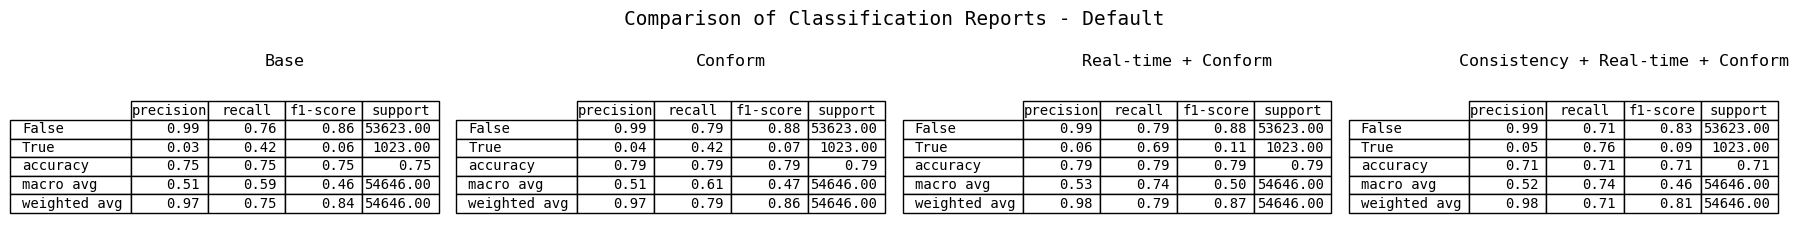

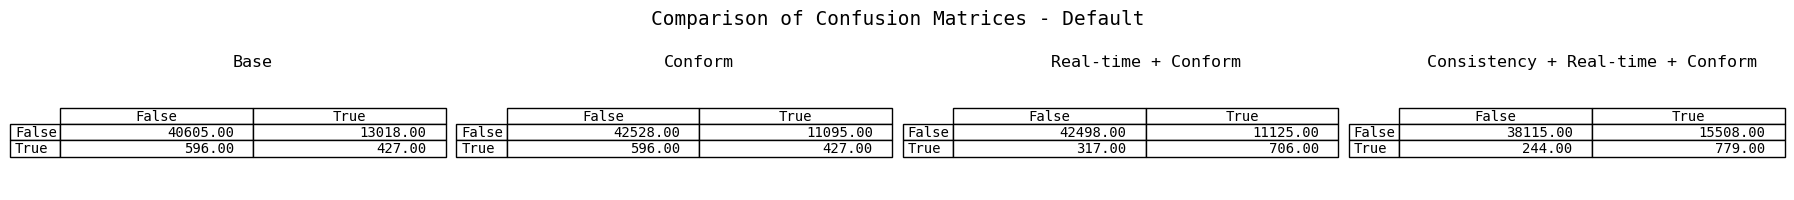

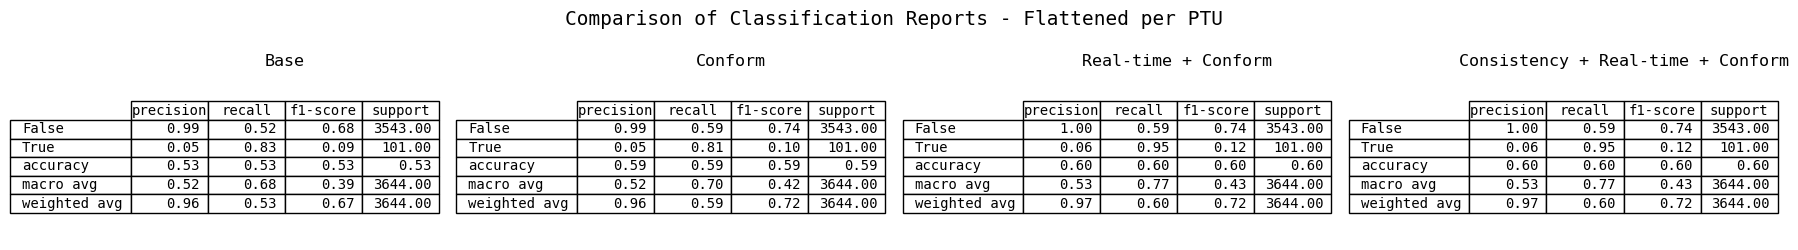

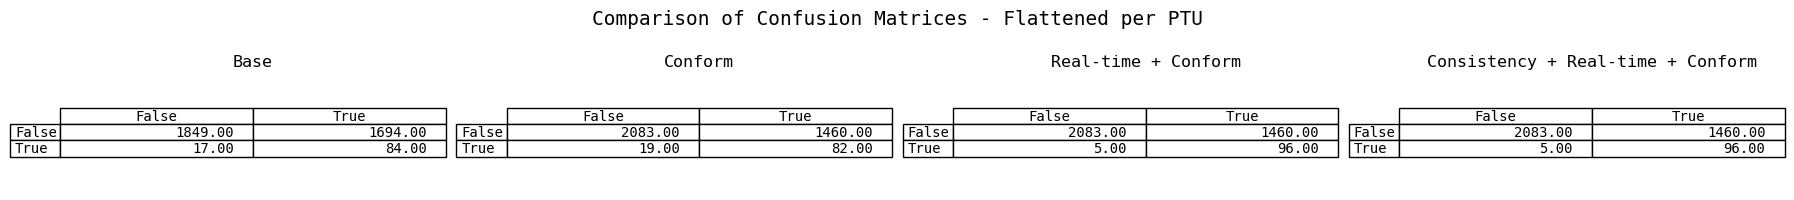

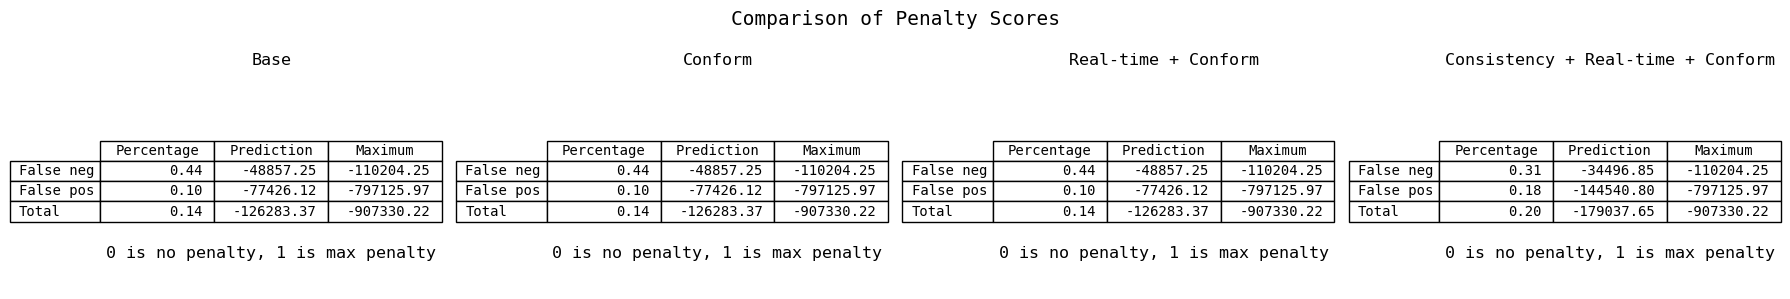

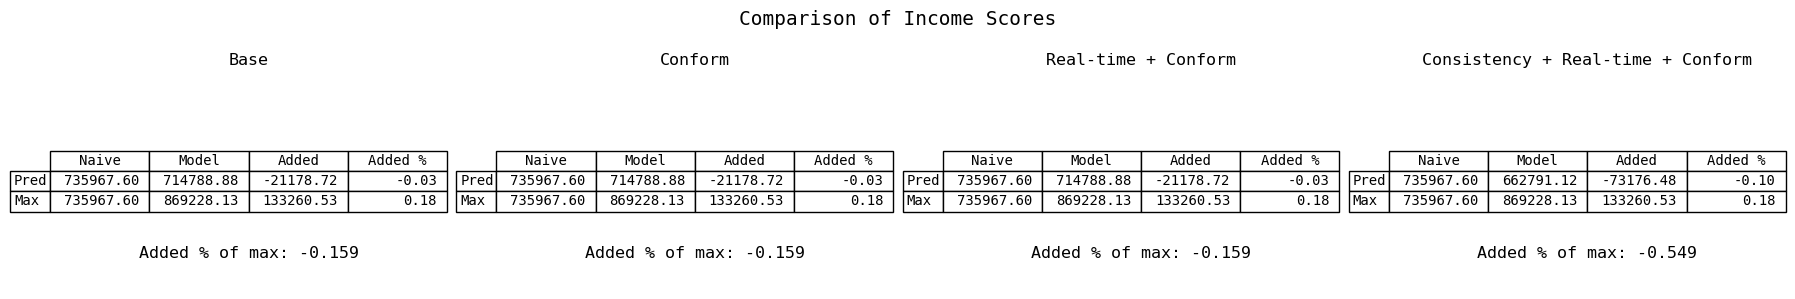

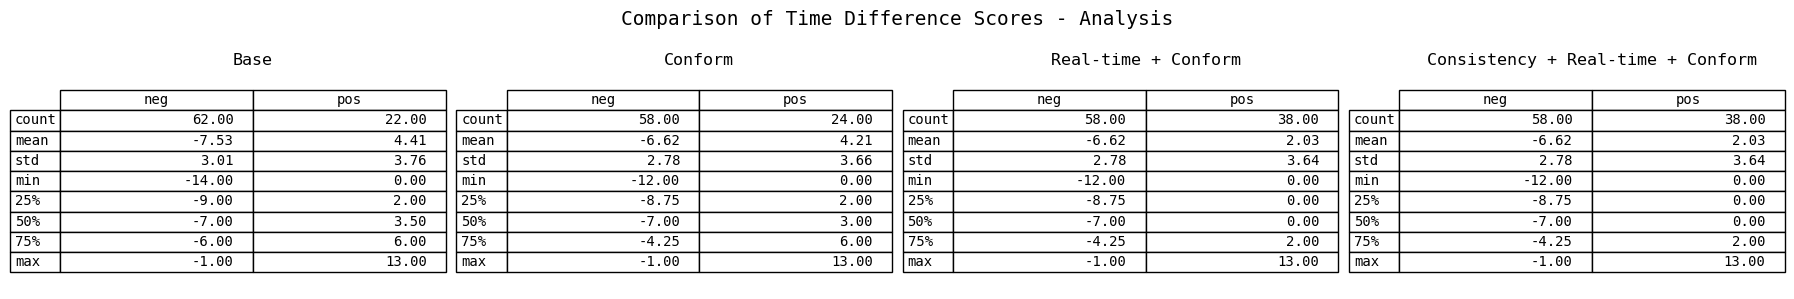

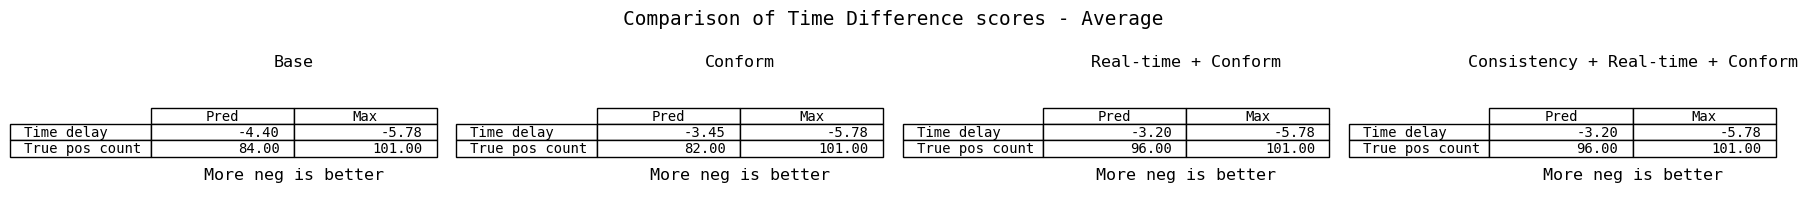

In [22]:
version = "target"
target = "income"
train_set = "train"
test_set = "test"

features = [
    "import_capacity",
    "min_price_published",
    "mid_price_published",
    "max_price_published",
    "min_ptu_price_known",
    "max_ptu_price_known",
    "fix_min_ptu_price_known",  # combine all
    "fix_max_ptu_price_known",  # combine all
    "fix_settlement_price_bestguess_alt",  # combine all
    "settlement_price_bestguess_alt",
    # "upward_dispatch_published",
    # "downward_dispatch_published",
    # "igcc_contribution_up_published",
    # "igcc_contribution_down_published",
    "time_since_last_two_sided",
    "time_since_last_two_sided_alt",  # combine all
    "two_sided_daily_count",
    "PTU",
    "minute_in_ptu",
    "naive_strategy_action",
    "vwap_avg",
    "vwap_std",
    "vwap_median",
    "vwap_qty_sum",
    "hvq_delta",
    # "forecast_wind",
    # "forecast_solar",
    # "forecast_demand",
    "forecast_wind_delta",
    "forecast_solar_delta",
    "forecast_demand_delta",
    # "fix_two_sided_ptu_realtime",
    "residual_load",
    "dispatch_diff",
    "igcc_diff",
    "is_balanced",
    "weekday",
    "workday",
    # "hour",
    "month",
    # "day",
    # "minute",
    "down_negative",
    "down_price_volume",
    "up_price_volume",
    # "diff_price_volume",
    # "started_down"
] + lagged_features
print("Number of used features:", len(features))
splits = get_splits(df, features, target, return_dict_pair=False)


def train(train_in, train_out):
    model = HistGradientBoostingRegressor(l2_regularization=8, learning_rate=0.05, validation_fraction=0.5, categorical_features="from_dtype", scoring="r2")
    # model = xgb.XGBClassifier(objective="binary:hinge", subsample=0.9, tree_method="hist", grow_policy="lossguide", max_depth=8)
    # model = HistGradientBoostingClassifier(scoring="average_precision", l2_regularization=8, learning_rate=0.05, validation_fraction=0.5, categorical_features="from_dtype")
    # model = RandomForestRegressor(n_estimators=200, criterion="poisson", max_features="log2", n_jobs=-1)
    # model = RandomForestClassifier(n_estimators=200, criterion="log_loss", max_features="log2", class_weight="balanced", n_jobs=-1)

    model = model.fit(train_in, train_out)
    return model


def test(model, test_in):
    pred = model.predict(test_in)
    return recast_pred(pred < 0), pred


# mask = ~splits[train_set][3]["minute_in_ptu"].isin([0, 1])  # Maybe prob no
splits[train_set][3]["down"] = splits[train_set][3]["min_price_published"].notna()
mask = splits[train_set][3].groupby("fix_ptu_id")["down"].transform("first")

# def upsample(train_in, train_out, factor=1):
#     sample_in = train_in[train_out]
#     sample_out = train_out[train_out]
#     for _ in range(factor):
#         train_in = pd.concat([train_in, sample_in])
#         train_out = pd.concat([train_out, sample_out])
#     return train_in, train_out

# splits[train_set][0], splits[train_set][1] = upsample(splits[train_set][0], splits[train_set][1])

# splits[test_set][3] = recast_categorical(splits[test_set][3], False)

best, _ = evaluate_income(train, test, splits[train_set][0][mask], splits[train_set][1][mask], splits[test_set][0], splits[test_set][3], repeat=8)

print(best[1])
p1, p1p = test(best[0], splits[test_set][0])
print(median_absolute_error(splits[test_set][1], p1p))
print(r2_score(splits[test_set][1], p1p))
print(d2_absolute_error_score(splits[test_set][1], p1p))
show_metrics_adjusted(splits[test_set][3], p1, version=version)

_, df["pred_income"] = test(best[0], splits["full"][0])

# TODO
# Make target the penalty
# Use the 2 min delay (done ish)
# price realized use
# Use ransac or something to better fit the minute in ptu
# Drop cutoff ptus
# Cache penalties
# Fix naive strategy action
# Fix pred fix max
# Skip train first 2 in ptu since it doesnt matter
# ...

Number of used features: 40
count    8.000000
mean     0.035205
std      0.001983
min      0.032997
25%      0.033348
50%      0.035118
75%      0.036924
max      0.037552
Name: 0, dtype: float64
0.03755170391945652


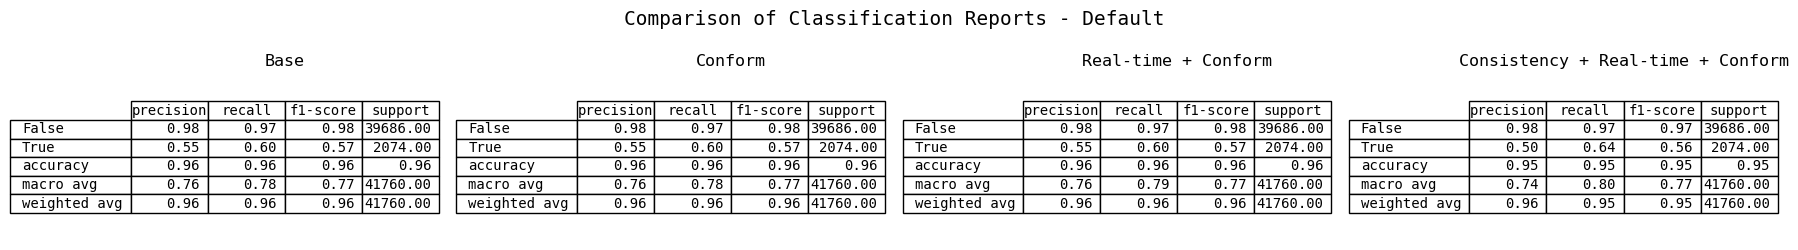

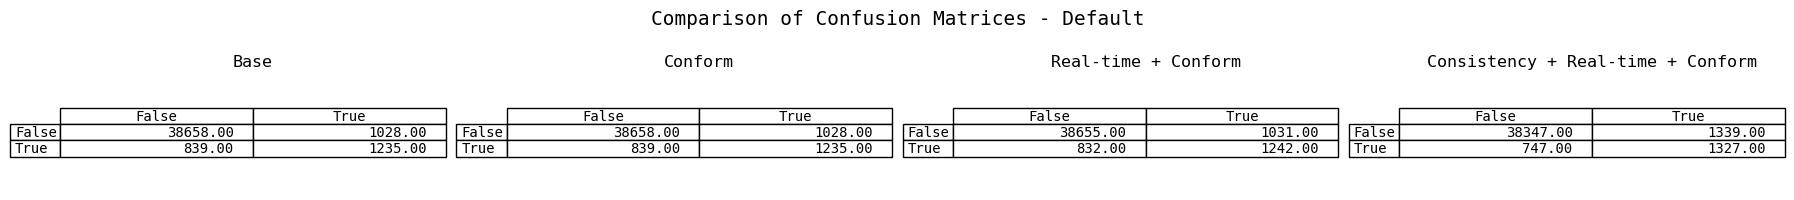

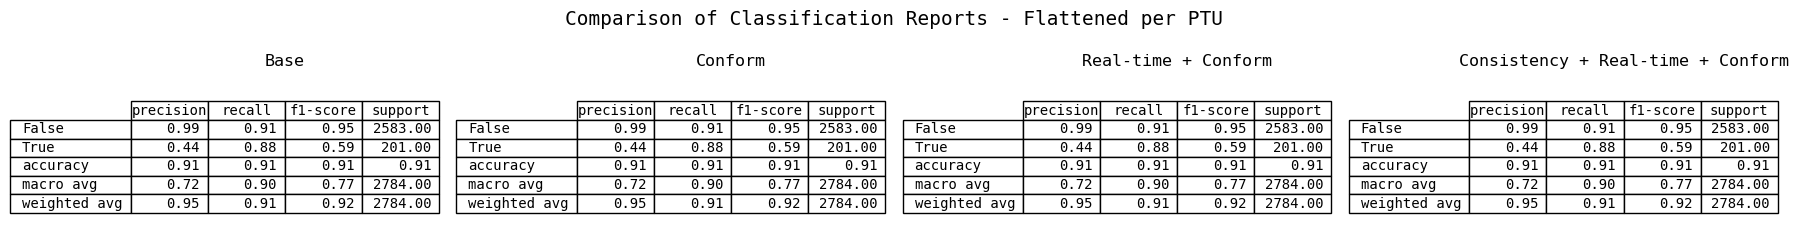

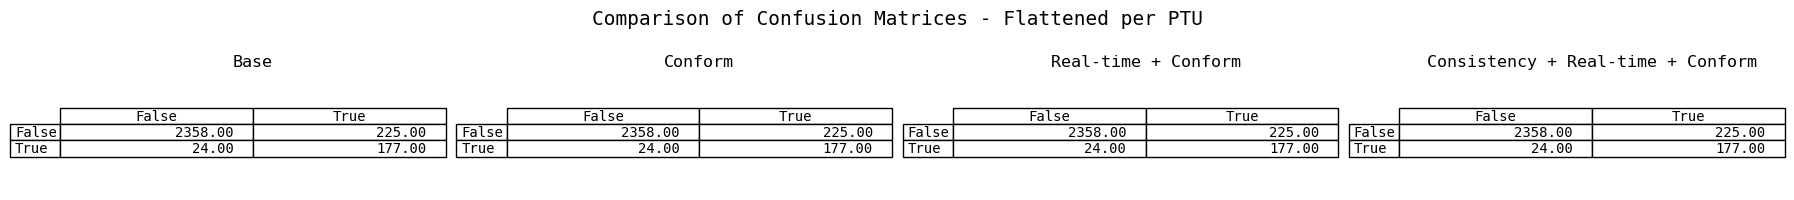

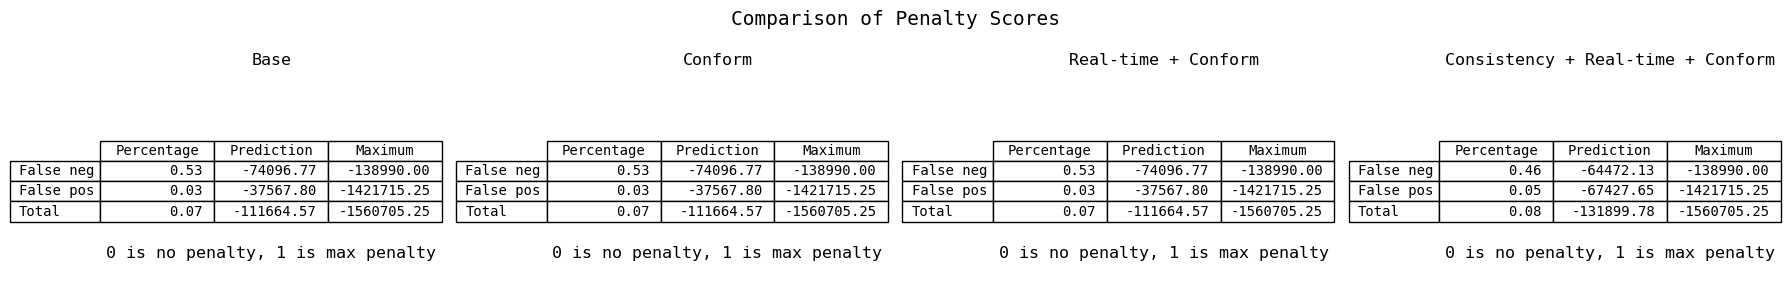

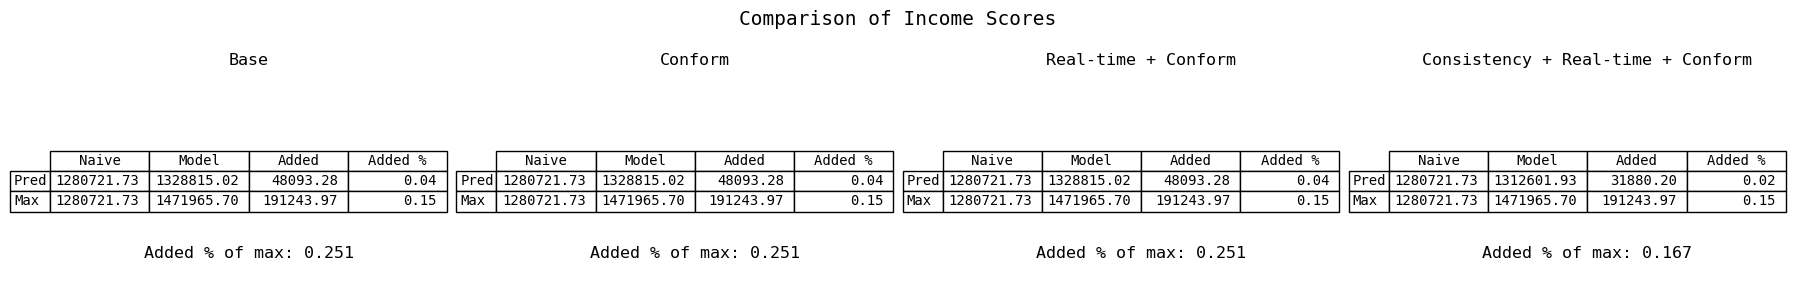

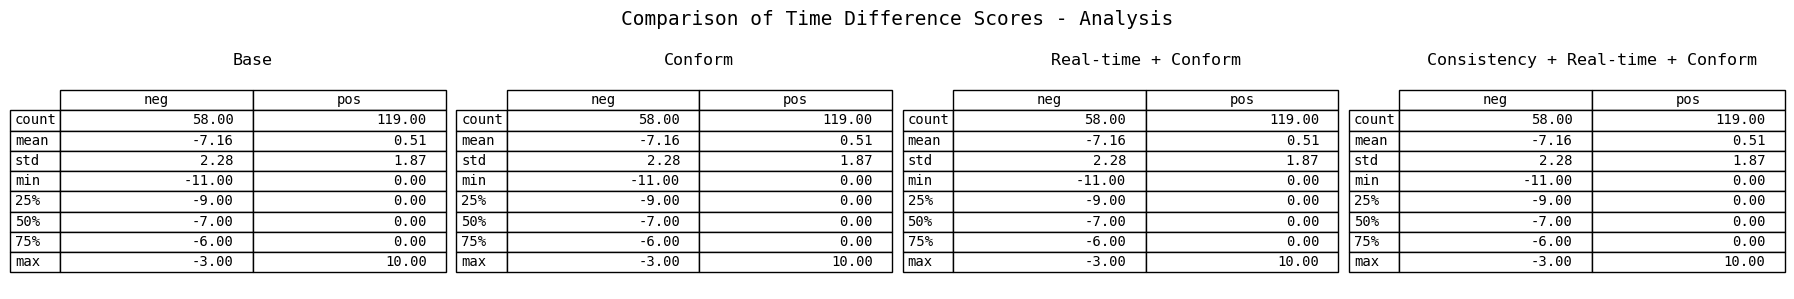

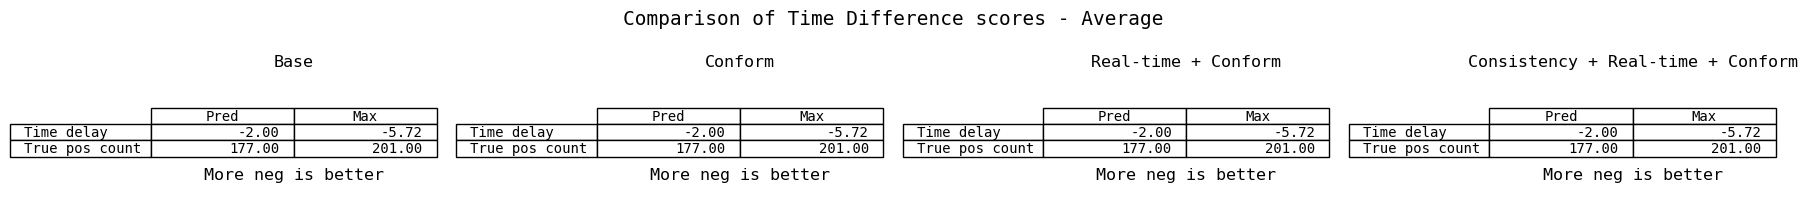

In [19]:
version = "target"
target = "fix_two_sided_ptu"
train_set = "train"
test_set = "valid"

# df = lag(df, "pred_income", 2)

features2 = features + ["pred_income"] #+ [df.columns[-1]]

print("Number of used features:", len(features2))
splits = get_splits(df, features2, target, return_dict_pair=False)


def train(train_in, train_out):
    model = HistGradientBoostingRegressor(loss="poisson", l2_regularization=8, learning_rate=0.05, validation_fraction=0.5, categorical_features="from_dtype")
    # model = xgb.XGBClassifier(objective="binary:hinge", subsample=0.9, tree_method="hist", grow_policy="lossguide", max_depth=8)
    # model = HistGradientBoostingClassifier(scoring="average_precision", l2_regularization=8, learning_rate=0.05, validation_fraction=0.5, categorical_features="from_dtype")
    # model = RandomForestRegressor(n_estimators=200, criterion="poisson", max_features="log2", n_jobs=-1)
    # model = RandomForestClassifier(n_estimators=200, criterion="log_loss", max_features="log2", class_weight="balanced", n_jobs=-1)

    model = model.fit(train_in, train_out)
    return model


def test(model, test_in):
    pred = model.predict(test_in)
    return recast_pred(pred > 0.5), pred


# mask = ~splits[train_set][3]["minute_in_ptu"].isin([0, 1])  # Maybe prob no
splits[train_set][3]["down"] = splits[train_set][3]["min_price_published"].notna()
mask = splits[train_set][3].groupby("fix_ptu_id")["down"].transform("first")

# def upsample(train_in, train_out, factor=1):
#     sample_in = train_in[train_out]
#     sample_out = train_out[train_out]
#     for _ in range(factor):
#         train_in = pd.concat([train_in, sample_in])
#         train_out = pd.concat([train_out, sample_out])
#     return train_in, train_out

# splits[train_set][0], splits[train_set][1] = upsample(splits[train_set][0], splits[train_set][1])

# splits[test_set][3] = recast_categorical(splits[test_set][3], False)

best2, _ = evaluate_income(train, test, splits[train_set][0][mask], splits[train_set][1][mask], splits[test_set][0], splits[test_set][3], repeat=8)

print(best2[1])
p2, p2p = test(best2[0], splits[test_set][0])
show_metrics_adjusted(splits[test_set][3], p2, version=version)

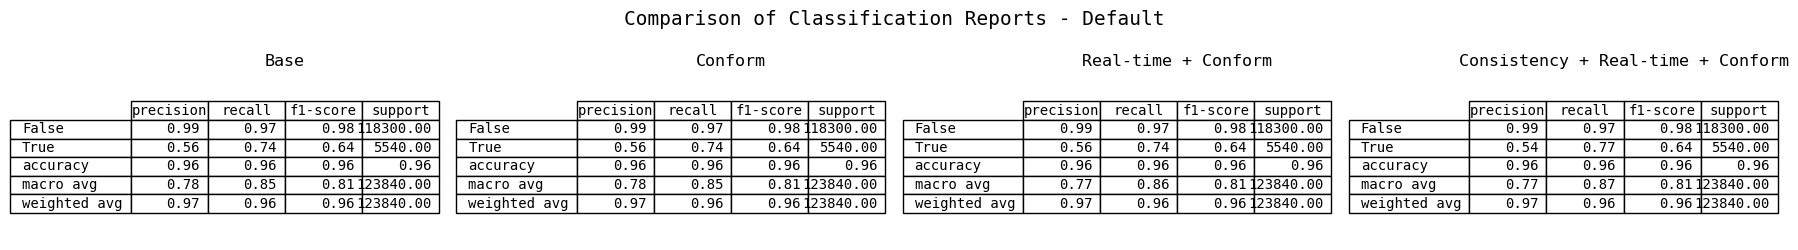

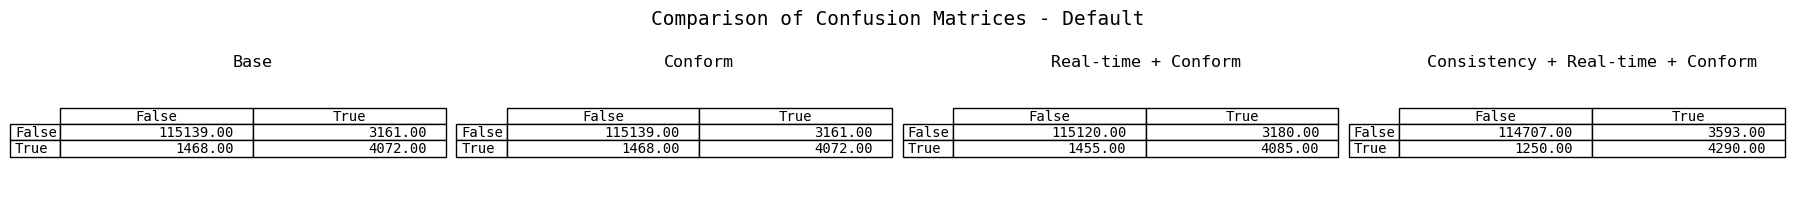

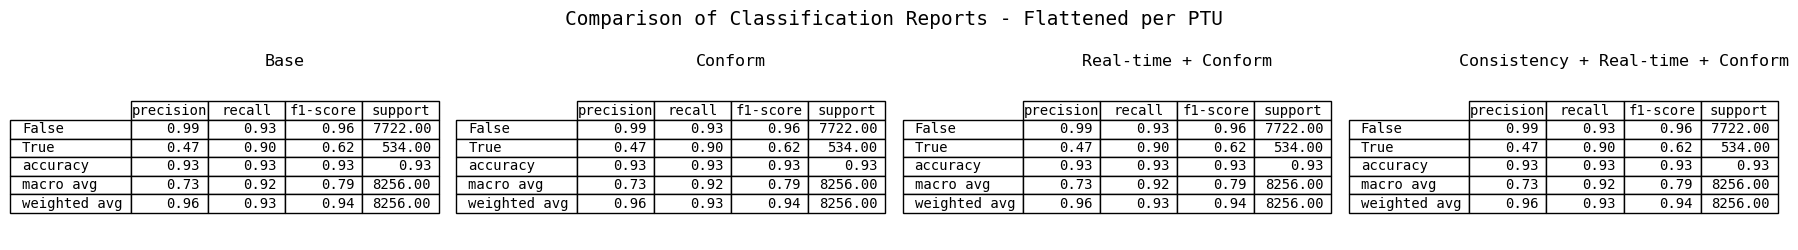

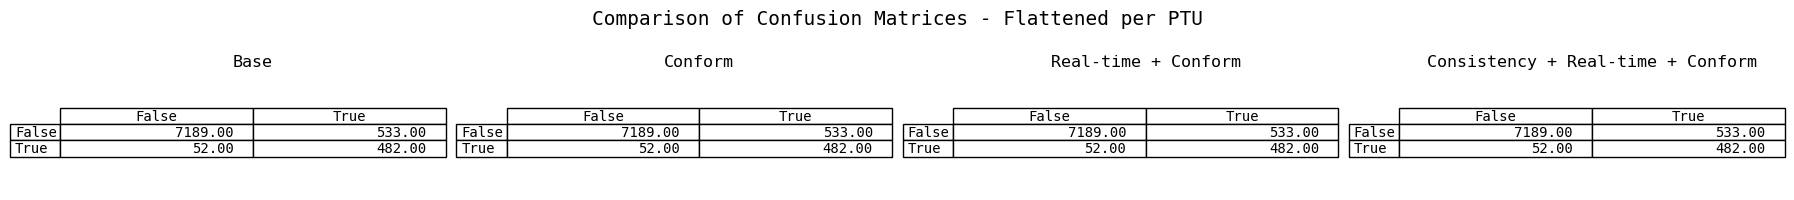

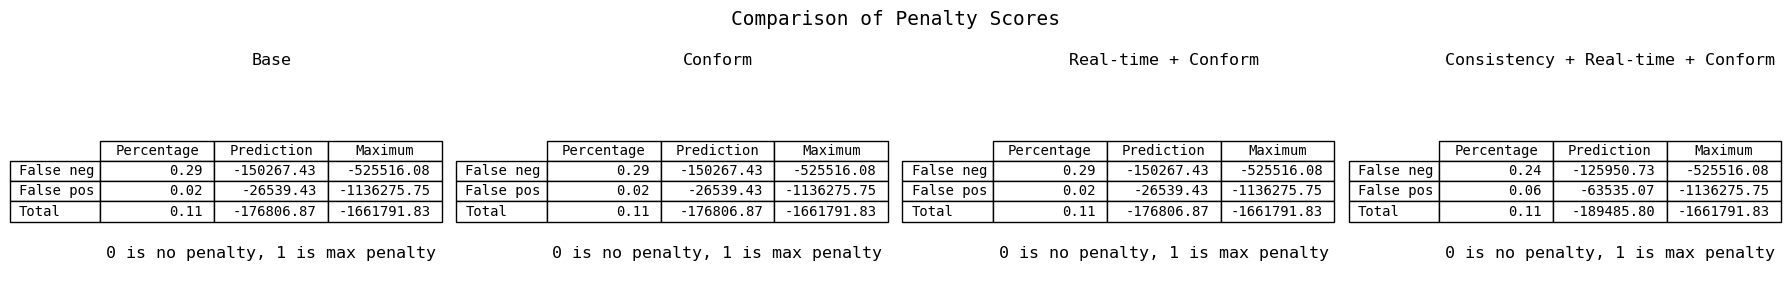

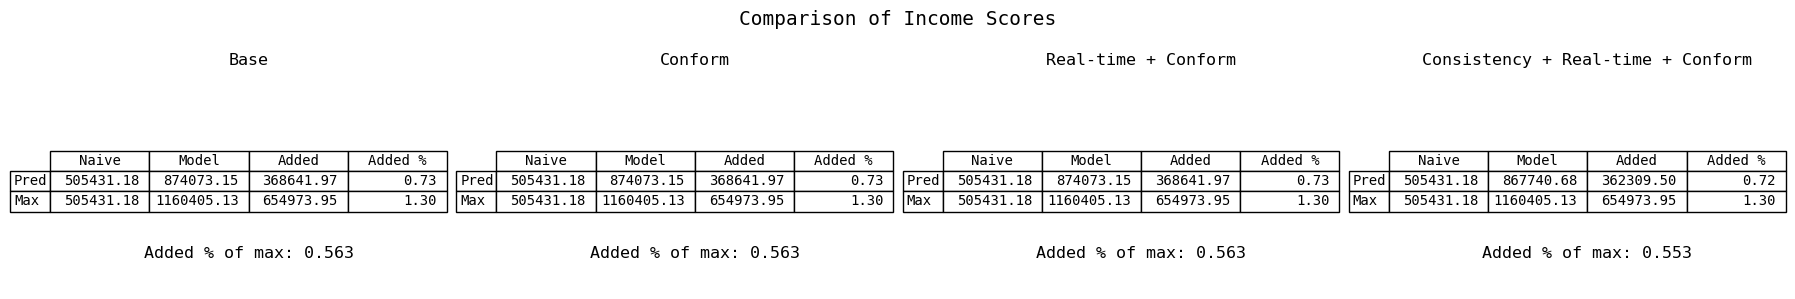

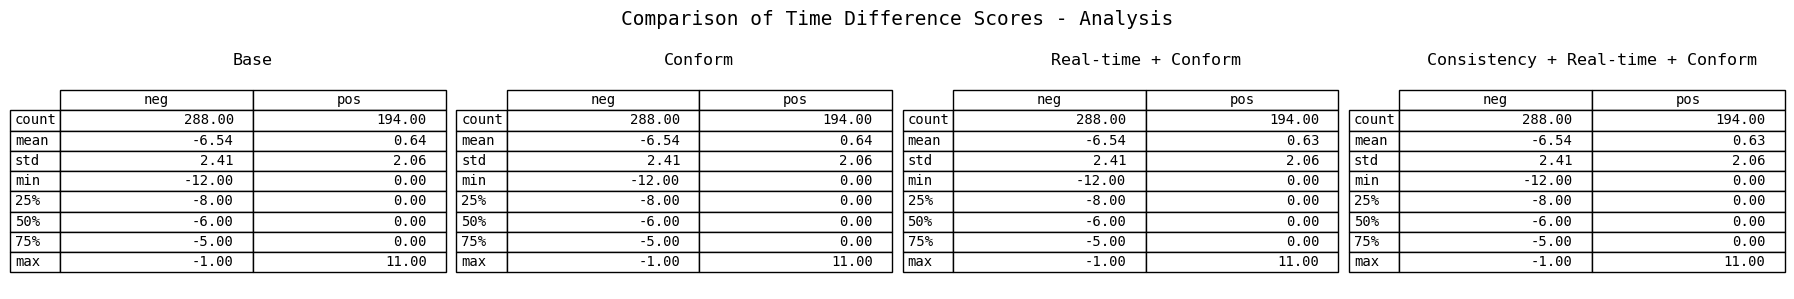

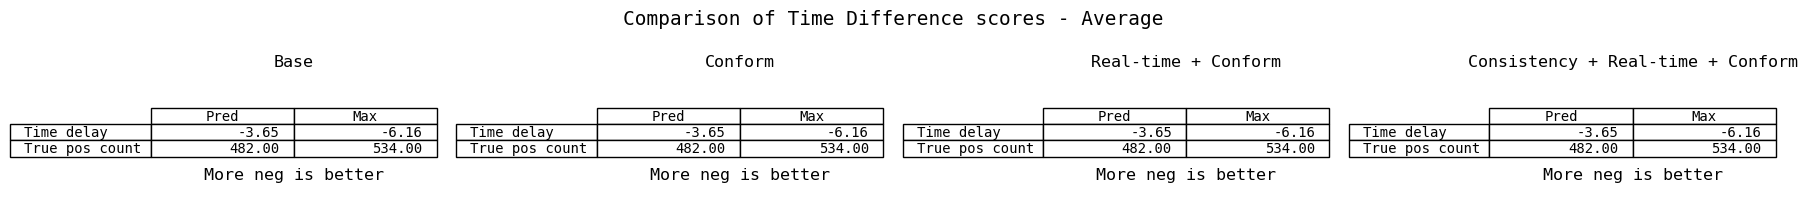

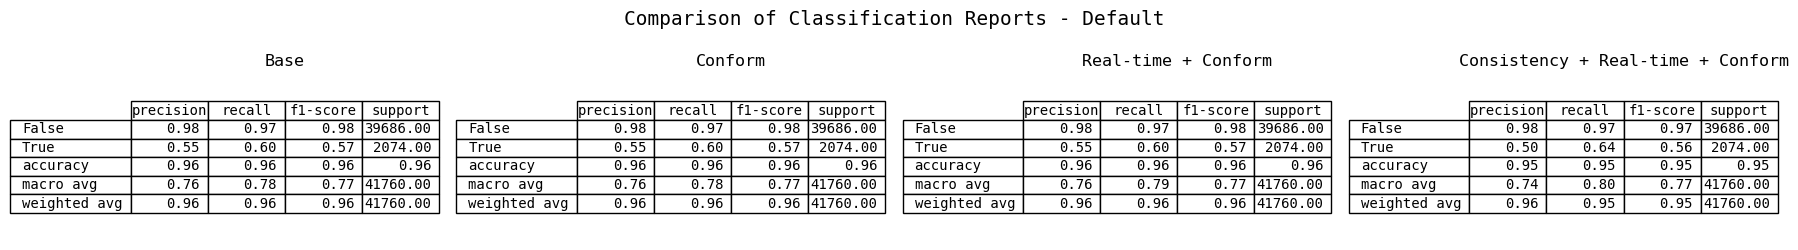

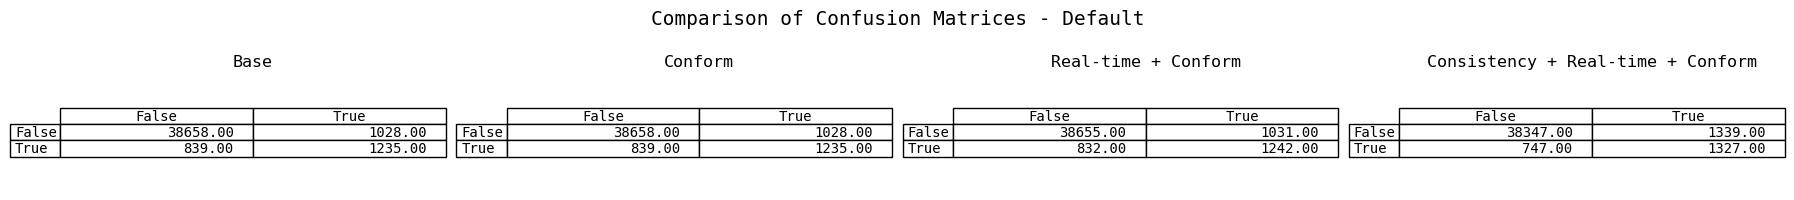

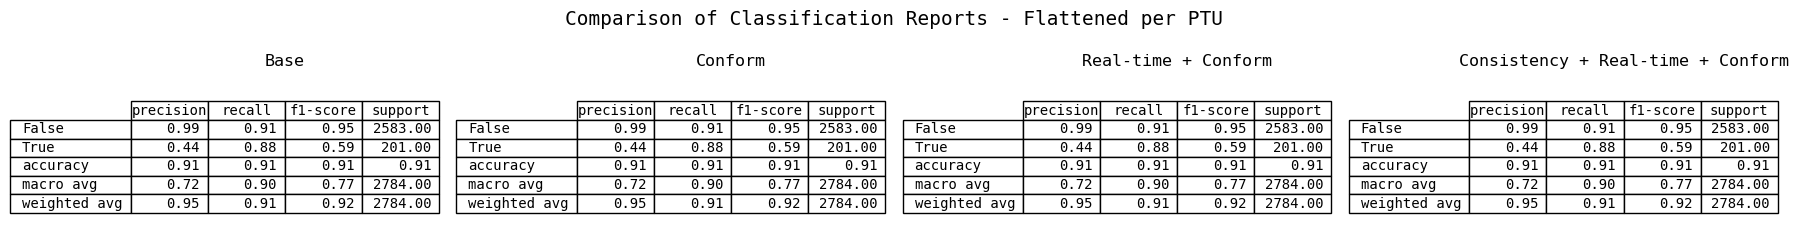

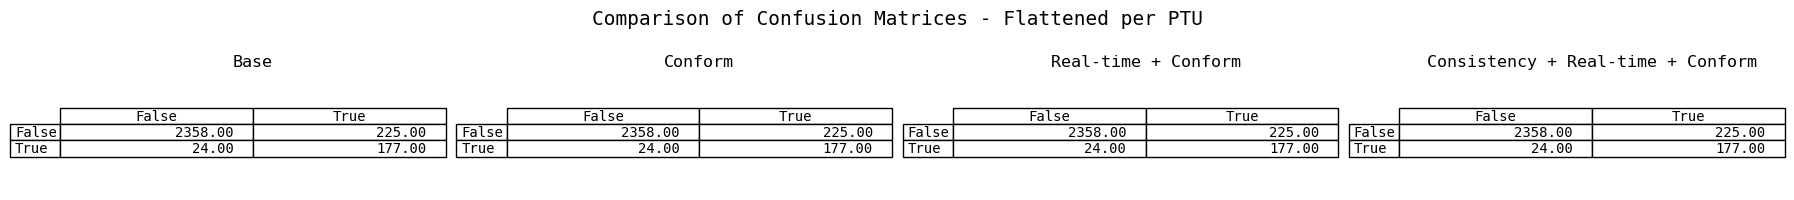

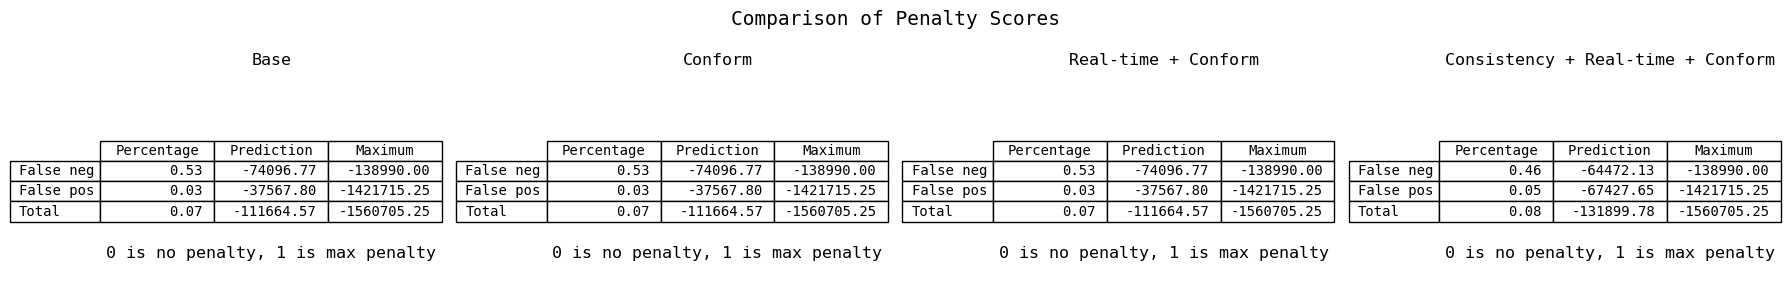

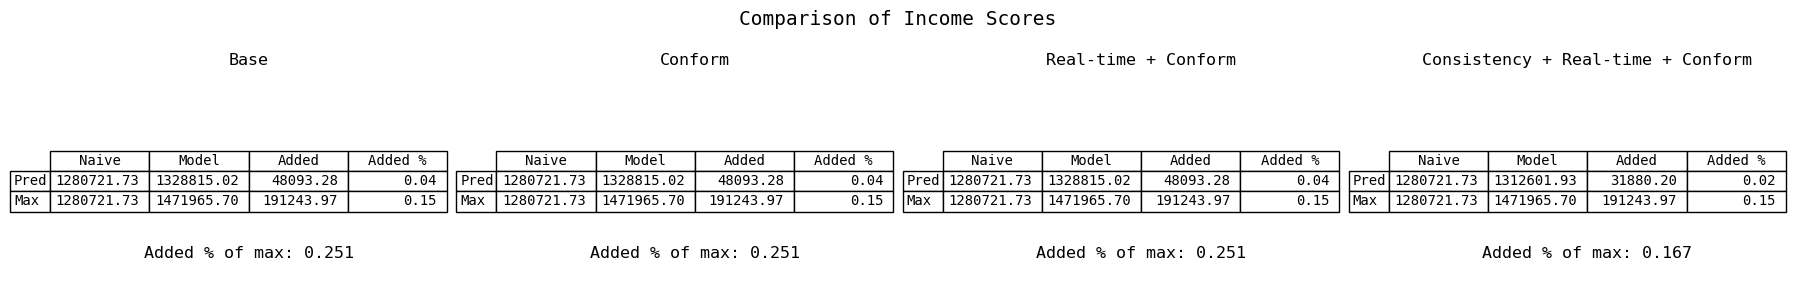

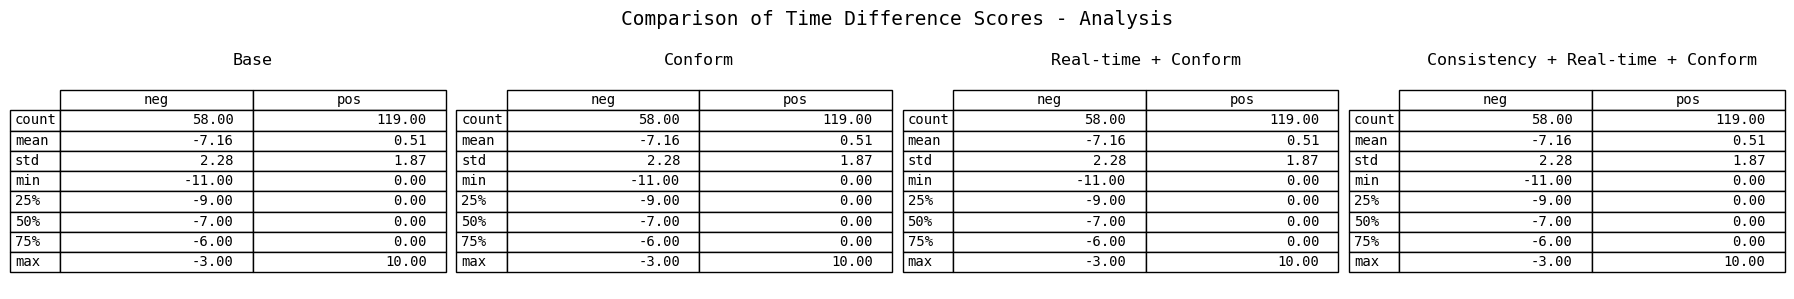

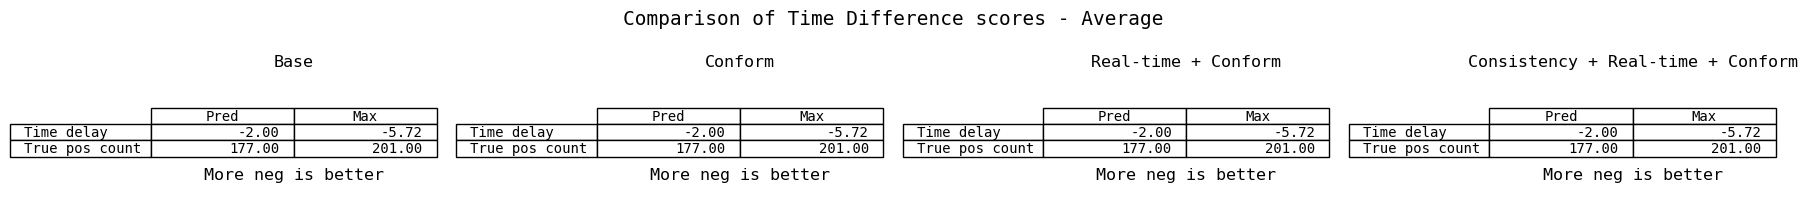

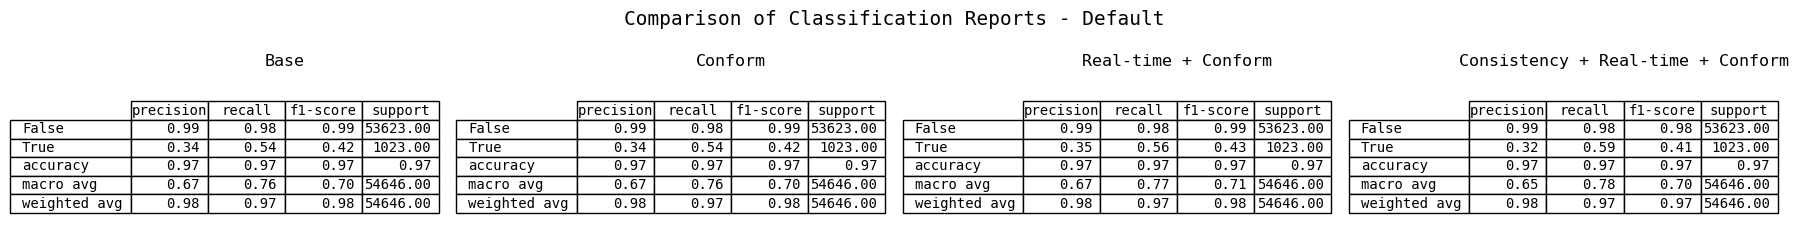

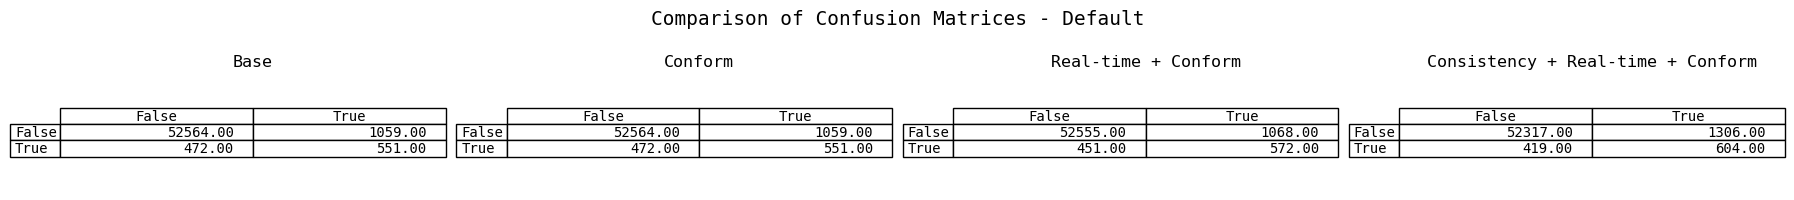

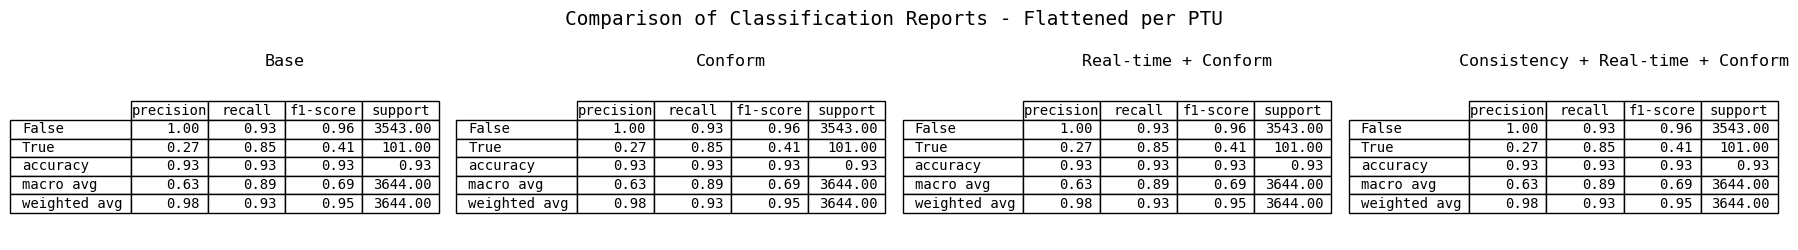

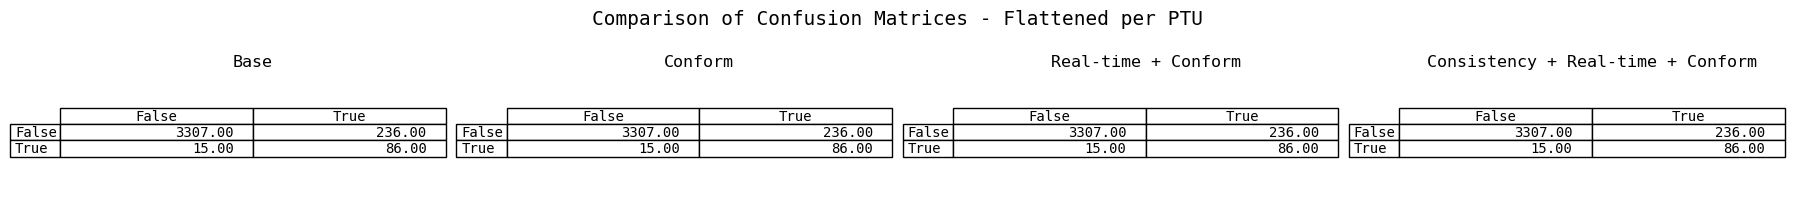

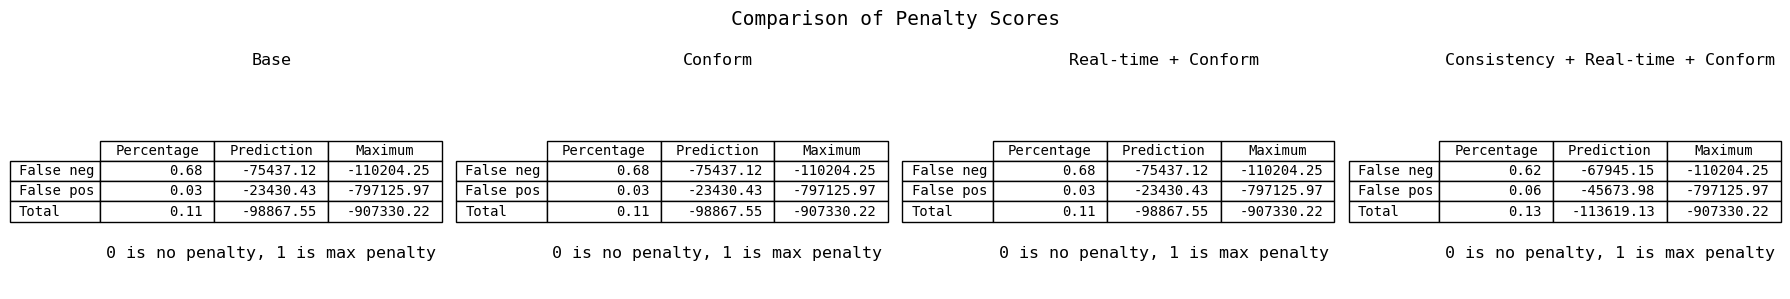

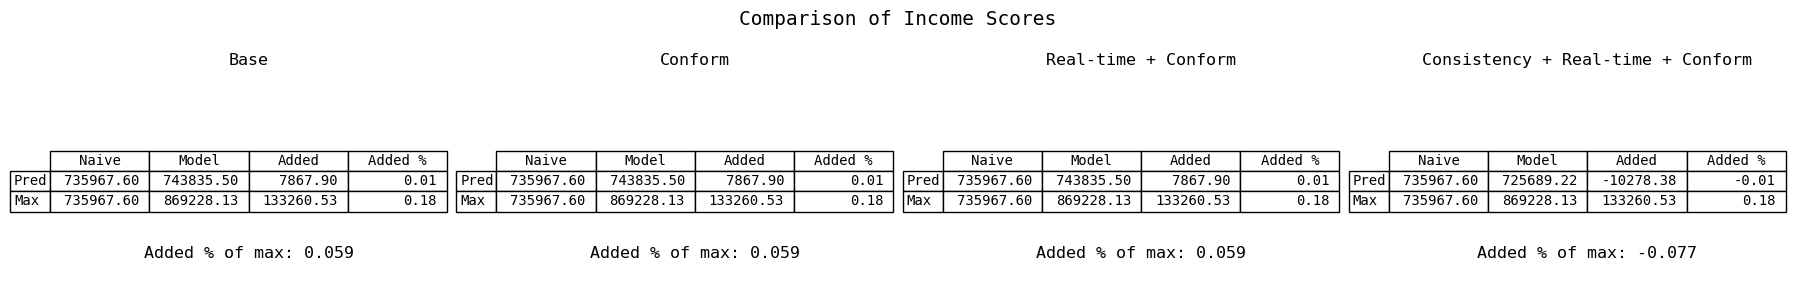

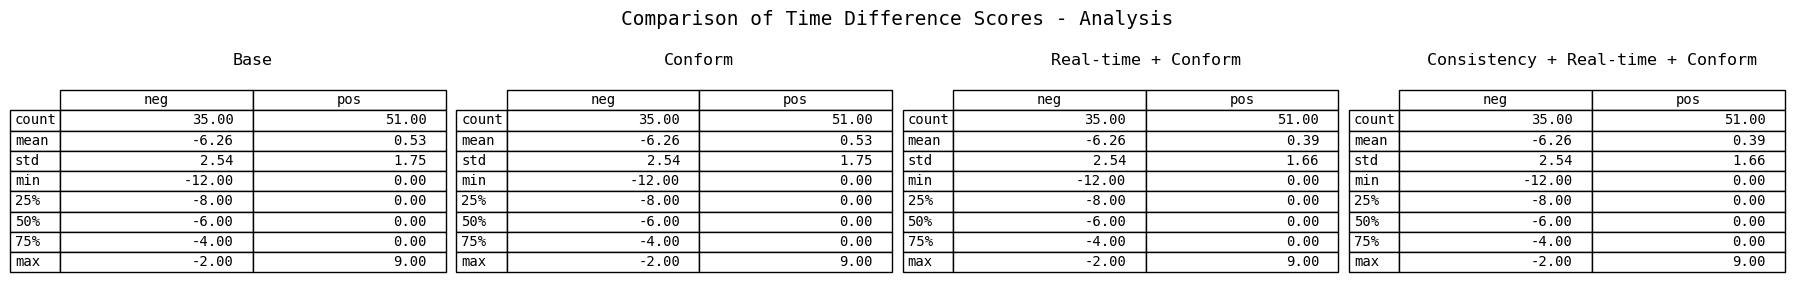

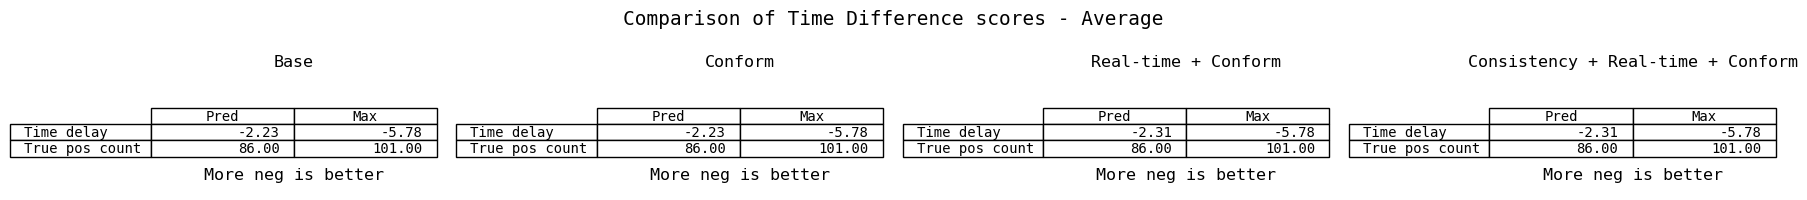

In [20]:
m = best2[0]

p_tr, _ = test(m, splits["train"][0])
show_metrics_adjusted(splits["train"][3], p_tr, version=version)

p_va, _ = test(m, splits["valid"][0])
show_metrics_adjusted(splits["valid"][3], p_va, version=version)

p_te, _ = test(m, splits["test"][0])
show_metrics_adjusted(splits["test"][3], p_te, version=version)

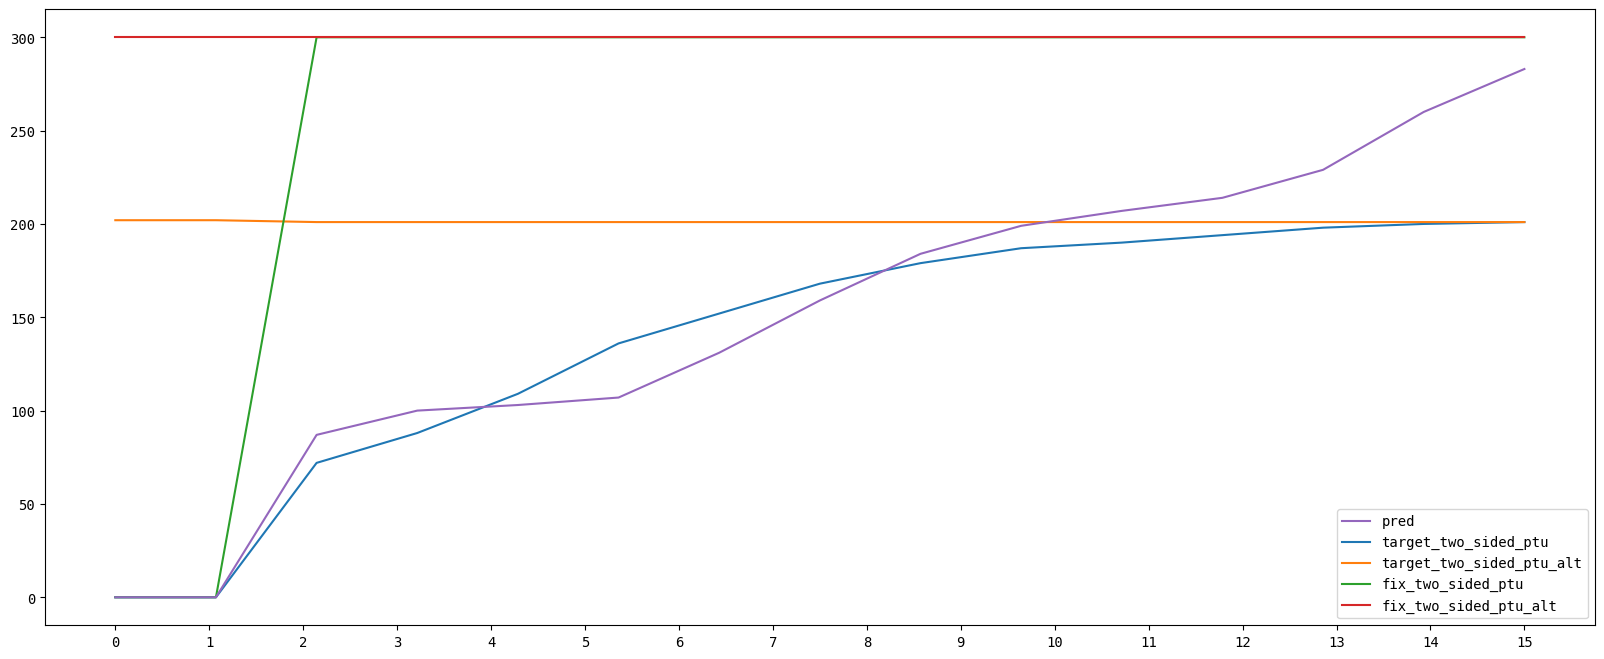

In [21]:
targets = [
    "target_two_sided_ptu",
    "target_two_sided_ptu_alt",
    # "target_two_sided_ptu_realtime",
    "fix_two_sided_ptu",
    "fix_two_sided_ptu_alt",
    # "fix_two_sided_ptu_realtime",
    "pred"
]
agg_dict = {t: "sum" for t in targets}
view = splits[test_set][3]
view["pred"] = p2
items = 15
flat_df = view.groupby("minute_in_ptu").agg(agg_dict)
flat_df.index = np.linspace(0, items, items)

for t in targets:
    plot_against_index(flat_df[t], show=False)
plt.xticks(range(0, items + 1, 1))
show_graph()